<a href="https://colab.research.google.com/github/Jabermbarki8/cats-vs-dogs-classification-CNN-VGG-16/blob/main/Cats_vs_dogs_Jabeur_Mbarki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect kaggle avec google colab pour enregistrer des bases volumineux sur google drive

In [ ]:
! pip install -q kaggle

In [ ]:
#création un dossier kaggle
! mkdir ~/.kaggle/

In [ ]:
! cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 97% 767M/788M [00:04<00:00, 237MB/s]
100% 788M/788M [00:04<00:00, 186MB/s]


In [ ]:
! unzip /content/microsoft-catsvsdogs-dataset.zip -d cats_dogs_data

# importation des packages nécessaires





In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import shutil, sys 
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
from keras.preprocessing import image


from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten,BatchNormalization
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

## **Préparation de données**

In [3]:
print(len(os.listdir('/content/drive/MyDrive/Kaggle/cats_dogs_data/PetImages/Cat')))
print(len(os.listdir('/content/drive/MyDrive/Kaggle/cats_dogs_data/PetImages/Dog')))

12501
12500


In [ ]:
source_path = '/content/drive/MyDrive/Kaggle/cats_dogs_data/PetImages' #Le chemin d'accés vers le dossier contenant les dossiers "dogs" & "cats"
source_path_dogs = os.path.join(source_path, 'Dog')    #Le chemin d'accés vers dossiers "dogs", on accéder au dossier à partir source_path déja défini
source_path_cats = os.path.join(source_path, 'Cat')    #Le chemin d'accés vers dossiers "cats", on accéder au dossier à partir source_path déja défini

In [ ]:
print(f"Il y a  {len(os.listdir(source_path_dogs))} images de chiens")
print(f"Il y a {len(os.listdir(source_path_cats))} images de chats.")

Il y a  12500 images de chiens
Il y a 12501 images de chats.


In [ ]:
# Création du nouvelle répertoire "cats_dogs_dats" pour faire une autre distribution des images
root_dir = '/content/drive/MyDrive/Kaggle/cats_dogs_dats'

# Répertoire vide pour empêcher FileExistsError si la fonction est exécutée plusieurs fois
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

In [ ]:
#Céation des répertoires pour train and validation data dans la répertoire définie ci-dessus
#    Le principe de cette fonction est de créer deux dossiers dans la répertoire "cats_dogs_dats", 
#    le 1er dossier pour le "training" et le 2éme pour la "validation", apès dans chaqu'un de ces
#    dossiers on va créer deux autres dossiers le 1er contenant les images "dogs" et l'autre les images "cats"
def create_train_val_dirs(root_path):
  os.mkdir(root_path)
  train_dir = os.path.join(root_path, 'training')
  os.mkdir(train_dir)
  val_dir = os.path.join(root_path, 'validation')
  os.mkdir(val_dir)
  cat_train_dir = os.path.join(train_dir, 'cats')
  os.mkdir(cat_train_dir)
  dog_train_dir = os.path.join(train_dir, 'dogs')
  os.mkdir(dog_train_dir)

  cat_val_dir = os.path.join(val_dir, 'cats')
  os.mkdir(cat_val_dir)
  dog_val_dir = os.path.join(val_dir, 'dogs')
  os.mkdir(dog_val_dir)
#Exception pour gérer l'erreur de l'éxistence des dossiers 
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
# Tester la fonction create_train_val_dirs 
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/drive/MyDrive/Kaggle/cats_dogs_dats/training
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation
/content/drive/MyDrive/Kaggle/cats_dogs_dats/training/cats
/content/drive/MyDrive/Kaggle/cats_dogs_dats/training/dogs
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation/cats
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation/dogs


In [ ]:
#Fonction pour créer notre base de train(random images seront séléctionner (cats+dogs) et de notre base de test de meme manière
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  source_list = os.listdir(SOURCE_DIR)
  train_list = random.sample(source_list, int(len(source_list)*SPLIT_SIZE))
  for img in source_list:
    if os.path.getsize(os.path.join(SOURCE_DIR, img)) == 0:
      print(img + "is zero length, so ignoring.")
    elif img in train_list:
      copyfile(os.path.join(SOURCE_DIR, img), os.path.join(TRAINING_DIR, img))
    else:
      copyfile(os.path.join(SOURCE_DIR, img), os.path.join(VALIDATION_DIR, img))

In [ ]:
# Définier les chemins d'accés 
CAT_SOURCE_DIR = "/content/drive/MyDrive/Kaggle/cats_dogs_data/PetImages/Cat"
DOG_SOURCE_DIR = "/content/drive/MyDrive/Kaggle/cats_dogs_data/PetImages/Dog"

TRAINING_DIR = "/content/drive/MyDrive/Kaggle/cats_dogs_dats/training"
VALIDATION_DIR = "/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/") 
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Répertoires vides au cas où vous exécuteriez cette cellule plusieurs fois
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Définir la proportion d'images utilisées pour le train
split_size = .9

In [ ]:
# Exécuter la fonction pour créer train et test data
# REMARQUE: Les messages sur les images de longueur nulle doivent être imprimés
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Vérifiez que le nombre d'images correspond à la sortie attendue

print(f"\n\nLe répertoire d'origine cats contient {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Le répertoire d'origine dogs contient {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"Il y a {len(os.listdir(TRAINING_CATS_DIR))} images cats pour le training")
print(f"Il y a {len(os.listdir(TRAINING_DOGS_DIR))} images dogs pour le training")
print(f"Il y a {len(os.listdir(VALIDATION_CATS_DIR))} images cats pour la validation")
print(f"Il y a {len(os.listdir(VALIDATION_DOGS_DIR))} images dogs pour la validation")

666.jpgis zero length, so ignoring.
11702.jpgis zero length, so ignoring.


Le répertoire d'origine cats contient 12501 images
Le répertoire d'origine dogs contient 12500 images

Il y a 11249 images cats pour le training
Il y a 11249 images dogs pour le training
Il y a 1251 images cats pour la validation
Il y a 1250 images dogs pour la validation


In [ ]:
# Supprime tous les fichiers non-image (il y en a deux .fichiers db regroupés dans l'ensemble de données)
!find "/content/drive/MyDrive/Kaggle/cats_dogs_dats/training" -type f ! -name "*.jpg" -exec rm {} +

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale=1/255,            #Transformer chaque valeur de pixel de la plage [0,255] à [0,1]
                                       horizontal_flip = True,   #Génére des images qui, de manière aléatoire, seront retournées horizontalement.
                                       fill_mode = 'nearest')    #La valeur de pixel la plus proche est choisie et répétée pour toutes les valeurs vides

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,             #produira 20 images à chaque itération de train. Une itération est définie comme 
                                                                                 #des étapes par époque, c'est-à-dire le nombre total d'échantillons / batch_size.
                                                      class_mode='binary',       #On seulement deux classes
                                                      target_size=(150, 150))    #Les images vont etres de taille 150*150

    validation_datagen = ImageDataGenerator(rescale=1/255,
                                       horizontal_flip = True,
                                       fill_mode = 'nearest')
   
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [ ]:
#Test de la fonction
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22497 images belonging to 2 classes.
Found 2501 images belonging to 2 classes.


# Modeling : Machine learning

In [ ]:
# Utile pour obtenir le nombre de classes
folders = glob('/content/drive/MyDrive/Kaggle/cats_dogs_dats/training'+'/*')
len(folders)

2

## **EarlyStopping**

In [ ]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5,     #Après 5 itération si on n'a pas d'amélioration on arrete le training
                          verbose=1,       #Affiche des messages lorsque le callback effectue une action.
                          mode='auto'      #La direction est automatiquement déduite du nom de la quantité surveillée ("val_loss" par défaut)
                         )

In [ ]:
callbacks = [earlystop]

# **CNN 4 conv layers**

In [ ]:
# create_model pour CNN en utilisant 4 CONVOLUTION LAYERS 
def create_model():
    model = tf.keras.models.Sequential([ 
        Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),  #16 filters, (3,3) kernal size (largeur & hauteur), input shape 150*150 taille image avec
                                                                          #3 couleurs 
        MaxPooling2D(2,2),    #(2, 2) (verticale, horizontale), réduira de moitié l'image dans chaque dimension
        Conv2D(32, (3,3), activation='relu'), # 32 filters
        MaxPooling2D(2,2), 
        Conv2D(64, (3,3), activation='relu'), #64 filters
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'), #128 filters
        MaxPooling2D(2,2),
        # Aplatir (flatten) les résultats pour alimenter un DNN (deep neural network)
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        Dense(512, activation='relu'),  
        # Seulement 1 neurone de sortie. Il contiendra une valeur de 0 à 1 où 0 pour classe ('chats') et 1 pour l'autre ('chiens')
        Dense(1, activation='sigmoid')
      ])
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 

    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
# Train the model
history = model.fit(train_generator,  #Train data
                    epochs=30,       #Nombre d'époques de training du model
                    verbose=1,       #Affiche des messages lorsque le callback effectue une action
                    validation_data=validation_generator,  #Validation data
                    callbacks=callbacks)

Epoch 1/30
 662/1125 [================>.............] - ETA: 49s - loss: 0.6410 - accuracy: 0.6160

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

1125/1125 [==============================] - 137s 113ms/step - loss: 0.6054 - accuracy: 0.6567 - val_loss: 0.5335 - val_accuracy: 0.7285
Epoch 2/30
1125/1125 [==============================] - 120s 107ms/step - loss: 0.4633 - accuracy: 0.7787 - val_loss: 0.4181 - val_accuracy: 0.8097
Epoch 3/30
1125/1125 [==============================] - 119s 106ms/step - loss: 0.3758 - accuracy: 0.8315 - val_loss: 0.3552 - val_accuracy: 0.8385
Epoch 4/30
1125/1125 [==============================] - 120s 107ms/step - loss: 0.3212 - accuracy: 0.8608 - val_loss: 0.3482 - val_accuracy: 0.8513
Epoch 5/30
1125/1125 [==============================] - 119s 106ms/step - loss: 0.2764 - accuracy: 0.8830 - val_loss: 0.3176 - val_accuracy: 0.8617
Epoch 6/30
1125/1125 [==============================] - 121s 107ms/step - loss: 0.2462 - accuracy: 0.8970 - val_loss: 0.3396 - val_accuracy: 0.8629
Epoch 7/30
1125/1125 [==============================] - 119s 106ms/step - loss: 0.2142 - accuracy: 0.9104 - val_loss: 0.280

Le model de CNN a fourni une accuracy de : 90.56%



In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

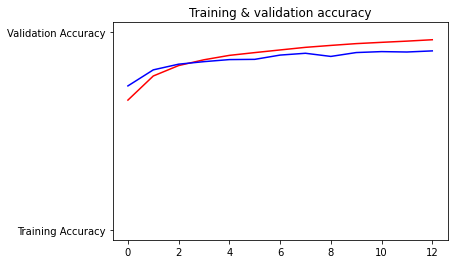

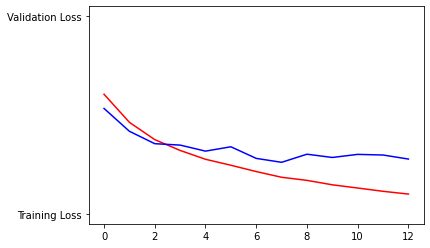

In [ ]:
epochs=range(len(acc)) # Nombre d'époques

#------------------------------------------------
# Visualiser training & validation accuracy par epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training & validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Visualiser training & validation loss par epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

# **VGG-16**

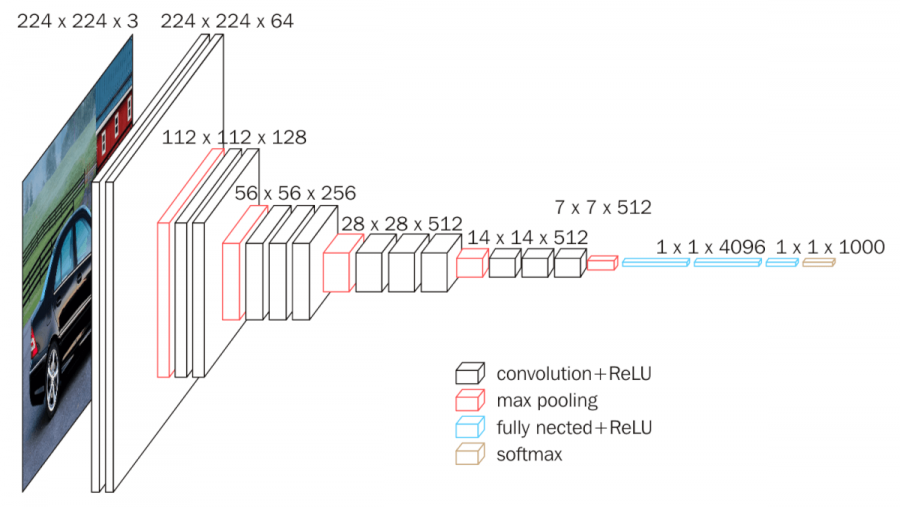

In [ ]:
vgg16_model = VGG16(weights = 'imagenet', include_top = False)  #'imagenet' indique que nous voulons utiliser les poids pré-entraînés pour le modèle respectif.
                                                                #En spécifiant l'argument include_top=False, vous chargez un réseau qui n'inclut pas les couches 
                                                                #de classification en haut
x = vgg16_model.output   # x contient les sorties à partir du model vgg-16 
x = GlobalAveragePooling2D()(x)       #effectue un sous-échantillonnage en calculant la moyenne des dimensions de hauteur et de largeur de l'entrée.
x = Dense(1024, activation='relu')(x)  #On ajoute un hidden layer de 1024 neurones et une fonction "relu" pour l'activation
predictions = Dense(1, activation = 'sigmoid')(x)  #Une couche de sortie donne un classification binaire (2 outputs) et une fonction "softmax" pour l'activation qui
                                                    #donne un proba
model1 = Model(inputs = vgg16_model.input, outputs = predictions)  #model1 généralise les étapes ci-dessus

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# figer toutes les couches du modèle pré-entraîné et entrainé seulement le classificateur
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
# Compiler le nouveau modèle à l'aide d'un optimiseur "adam"
model1.compile(optimizer = 'adam',
    loss = 'binary_crossentropy',  # "binary_crossentropy" pour classification binaire
    metrics = ['accuracy'])

In [ ]:
# fit le model
vgg16_history = model1.fit_generator(
    train_generator,
    epochs = 30,    #30 époques de training
    validation_data = validation_generator,
    callbacks=callbacks)

Epoch 1/30


<ipython-input-60-b19e0c8e7142>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_history = model1.fit_generator(


   3/1125 [..............................] - ETA: 1:41 - loss: 0.6391 - accuracy: 0.5667

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

1125/1125 [==============================] - 146s 128ms/step - loss: 0.2730 - accuracy: 0.8828 - val_loss: 0.2471 - val_accuracy: 0.8988
Epoch 2/30
1125/1125 [==============================] - 132s 117ms/step - loss: 0.2338 - accuracy: 0.8991 - val_loss: 0.2565 - val_accuracy: 0.8948
Epoch 3/30
1125/1125 [==============================] - 130s 116ms/step - loss: 0.2202 - accuracy: 0.9050 - val_loss: 0.2394 - val_accuracy: 0.8996
Epoch 4/30
1125/1125 [==============================] - 132s 117ms/step - loss: 0.2067 - accuracy: 0.9103 - val_loss: 0.2536 - val_accuracy: 0.8916
Epoch 5/30
1125/1125 [==============================] - 132s 117ms/step - loss: 0.1987 - accuracy: 0.9166 - val_loss: 0.2297 - val_accuracy: 0.9000
Epoch 6/30
1125/1125 [==============================] - 131s 116ms/step - loss: 0.1889 - accuracy: 0.9207 - val_loss: 0.2421 - val_accuracy: 0.9032
Epoch 7/30
1125/1125 [==============================] - 131s 116ms/step - loss: 0.1806 - accuracy: 0.9227 - val_loss: 0.232

Le model de VGG-16 a fourni : 90.44% d'accuracy

In [ ]:
acc_vgg16=vgg16_history.history['accuracy']
val_acc_vgg16=vgg16_history.history['val_accuracy']
loss_vgg16=vgg16_history.history['loss']
val_loss_vgg16=vgg16_history.history['val_loss']

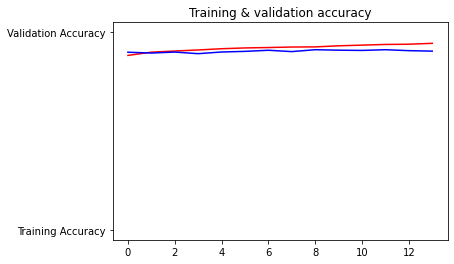

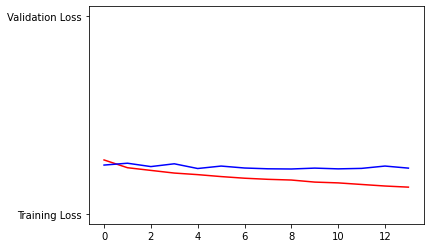

In [ ]:
epochs=range(len(acc_vgg16)) # Nombre d'époques

#------------------------------------------------
# Visualiser training & validation accuracy par epoch
#------------------------------------------------
plt.plot(epochs, acc_vgg16, 'r', "Training Accuracy")
plt.plot(epochs, val_acc_vgg16, 'b', "Validation Accuracy")
plt.title('Training & validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Visualiser training & validation loss par epoch
#------------------------------------------------
plt.plot(epochs, loss_vgg16, 'r', "Training Loss")
plt.plot(epochs, val_loss_vgg16, 'b', "Validation Loss")
plt.show()

# **Prédiction avec les modeles sur des images téléchargées**

## Visualisation des images

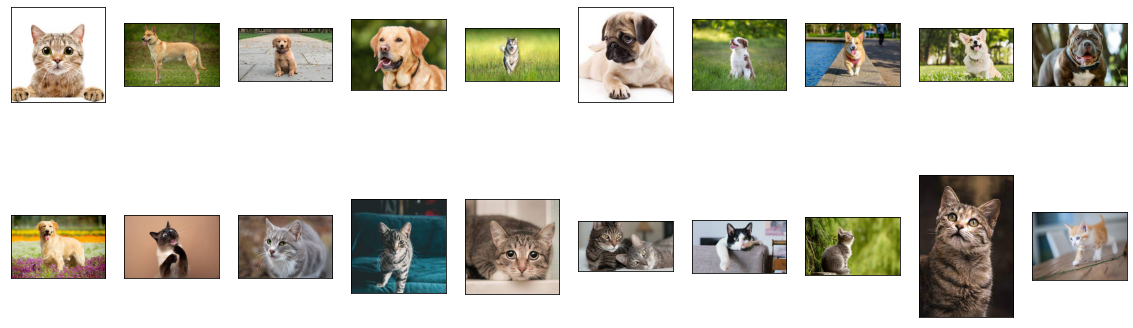

In [ ]:
import glob
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('/content/drive/MyDrive/Kaggle/images_prediction/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 10
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

In [ ]:
import numpy as np
# charger toutes les images dans une liste
images = []
for img in os.listdir('/content/drive/MyDrive/Kaggle/images_prediction'):
    img = os.path.join('/content/drive/MyDrive/Kaggle/images_prediction', img)
    img = tf.keras.utils.load_img(img, target_size=(150, 150))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

# empilez la liste des images à passer pour la prédiction
images = np.vstack(images)

## Prédiction avec CNN 4 conv layers

In [ ]:
classes = model.predict(images)
print(classes)

2/2 [==============================] - 0s 8ms/step
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

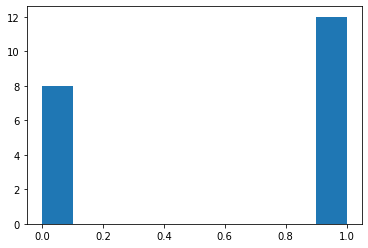

In [ ]:
plt.hist(classes)

Le model de CNN a échoué de prédire 2 chats correctement, il les classes en tant que chiens ! Et tous les chiens sont biens prédits


## Prédiction avec VGG-16

In [ ]:
classes_vgg16 = model1.predict(images)
print(classes_vgg16)

2/2 [==============================] - 0s 53ms/step
[[0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.7570536e-14]
 [0.0000000e+00]
 [0.0000000e+00]]


(array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

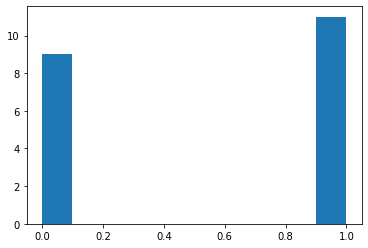

In [ ]:
plt.hist(classes_vgg16)

Le VGG-16 a échoué de classer seulement un chat, et il a réeussi a prédire tous les chiens correctement .